## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Import modules, set options

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


#### Filter

In [5]:
#train_csv, _ = train_test_split(train_csv, test_size=0.99, random_state=42)

#### Train_CSV Params

In [6]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,6.915783e+04,1.335689e+01,5.883966e+00,1.589904e+01
std,3.661127e+04,3.267712e+00,4.993943e+00,3.477050e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,3.900200e+04,1.100000e+01,2.000000e+00,-2.549780e-01
50%,7.160900e+04,1.300000e+01,5.000000e+00,2.281130e+00
75%,1.008060e+05,1.600000e+01,8.000000e+00,7.390655e+00
max,1.338840e+05,2.800000e+01,2.800000e+01,2.048800e+02


In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))



def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframeOld(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [20]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [21]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [22]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


## Check Regressions for a simple type

## New heading

In [23]:
def switch_to_local_coor(df):
    df['x'] = df['x'] - df['x_c'];
    df['y'] = df['y'] - df['y_c'];
    df['z'] = df['z'] - df['z_c'];
    
def add_distance_to_center(df):
    df['d_c'] = ((
        ( df['x'])**np.float32(2) +
        ( df['y'])**np.float32(2) + 
        ( df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_axis(df):
    n_x = df.x_0 - df.x_c
    n_y = df.y_0 - df.y_c
    n_z = df.z_0 - df.z_c
    axisFrame = pd.concat([n_x, n_y, n_z], axis=1)
    axisNorm = np.sqrt(np.square(axisFrame).sum(axis=1))
    df['a_x'] = axisFrame[0] / axisNorm
    df['a_y'] = axisFrame[1] / axisNorm
    df['a_z'] = axisFrame[2] / axisNorm

def add_cylindrical_coor(df):
    dist =  (df['a_x'] * df['x'] + df['a_y'] * df['y'] + df['a_z'] * df['z'])
    df['dist_along'] =  dist
    proj = pd.concat([df['a_x'] * dist, 
                      df['a_y'] * dist, 
                      df['a_z'] * dist                     
                     ], axis=1)
    vectorFromAxis = pd.concat([df['x'] - proj[0], 
                      df['y'] - proj[1], 
                      df['z'] - proj[2]], axis=1)
    r = np.sqrt(np.square(vectorFromAxis).sum(axis=1))
    df['r'] = 1 / r
    
def calc_cylindrical_coor(localCoor, axis):
    distAlongAxis =  np.dot(localCoor, axis)
    projectionOnAxis = axis * distAlongAxis
    vectorFromAxis = localCoor - projectionOnAxis    
    r = np.linalg.norm(vectorFromAxis)
    return distAlongAxis, r    
    
def add_dist_along_1(df):
    localFrame = pd.concat([df['x_1'] - df['x_c'], 
                            df['y_1'] - df['y_c'], 
                            df['z_1'] - df['z_c']], axis=1)
    df['dist_along_1'] = df['a_x'] * localFrame[0] + df['a_y'] * localFrame[1] + df['a_z'] * localFrame[2]
    
def build_atoms(base_from, structures_from, n_atoms):
    base = base_from
    structures = structures_from

    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in atoms:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)

    add_center(atoms)

    atoms = merge_all_atoms(atoms, structures)
    switch_to_local_coor(atoms)
    
    add_distance_to_center(atoms)

    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]
    
    
    add_axis(atoms)
    add_cylindrical_coor(atoms)

    #return atoms
     
    atoms = atoms.drop(['x', 'y', 'z',
                           'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    #atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms = atoms.drop(['atom_index'], axis=1)
    atoms = atoms.set_index(['x_c', 'y_c', 'z_c', 'a_x', 'a_y', 'a_z',
        'molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    #atoms = atoms.set_index(['x_0', 'y_0', 'z_0','x_c', 'y_c', 'z_c','molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()

    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    return atoms

def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

def build_coors(some_csv, structures_csv, coupling_type, n_atoms):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    atoms = build_atoms(base, structures, n_atoms)
    full = add_atoms(base, atoms)
    add_dist_along_1(full)
    return full


def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    full = build_coors(some_csv, structures_csv, coupling_type, n_atoms)    
    full.sort_values('id', inplace=True)
    return full


In [24]:
%%time
molecule_index = 55
some_csv = train_csv[train_csv.molecule_index == molecule_index]
coupling_type = '1JHC'
n_atoms = 10

base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
base = add_coordinates(base, structures, 0)
base = add_coordinates(base, structures, 1)
base = base.drop(['atom_0', 'atom_1'], axis=1)


atoms = build_atoms(base, structures, n_atoms)
full = add_atoms(base, atoms)
atoms
#atoms

Wall time: 140 ms


,x_c,y_c,z_c,a_x,a_y,a_z,molecule_index,atom_index_0,atom_index_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,dist_along_2,dist_along_3,dist_along_4,dist_along_5,dist_along_6,dist_along_7,dist_along_8,dist_along_9,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9
0,-1.704318,-0.389964,0.418053,-0.519664,0.291416,0.803135,55,13,3,1,1,6,6,6,1,1,8,-0.895909,-0.895918,-1.093461,-0.652539,-0.652467,0.437582,0.437649,-2.518928,0.964747,0.964749,0.699534,0.396573,0.396567,0.381008,0.380995,0.781694
1,-1.679338,-0.374220,-0.469721,-0.473993,0.320211,-0.820241,55,11,3,1,1,6,8,6,1,1,6,-0.886697,-0.895915,-1.076827,-0.547919,-0.564655,0.528919,-0.911063,-2.611718,0.961912,0.964736,0.696491,0.425415,0.396235,0.393336,0.359788,0.689046
2,-1.409752,-1.095961,-0.033399,0.018973,-0.999569,-0.022381,55,12,3,1,1,6,8,6,1,1,6,-0.886697,-0.895906,-1.076832,-0.547853,-0.564798,0.528773,-0.911360,-2.611723,0.961912,0.964733,0.696491,0.425415,0.396230,0.393316,0.359779,0.689082
3,-0.265354,1.745763,0.440355,-0.469037,0.370895,0.801524,55,7,0,1,1,6,6,6,1,1,8,-0.878467,-0.895254,-1.109804,-0.679523,-0.674260,0.409365,0.415224,-2.540912,0.956376,0.964342,0.699698,0.396769,0.395975,0.381205,0.379505,0.721165
4,-0.261578,1.724863,-0.447765,-0.462668,0.333100,-0.821574,55,6,0,1,1,6,8,6,1,1,1,-0.888441,-0.895027,-1.078701,-0.547493,-0.571997,0.521571,-0.844034,-0.924547,0.959509,0.963243,0.694055,0.411815,0.396245,0.393346,0.389580,0.361446
5,0.502527,1.741455,0.002169,0.932006,0.362441,0.001171,55,5,0,1,1,6,1,8,6,1,1,-0.878817,-0.889009,-1.092244,0.269938,-0.692857,-0.576354,0.520128,-0.907893,0.957916,0.962149,0.696230,0.407994,0.412546,0.395502,0.391739,0.359423
6,0.521342,-0.360024,1.713550,-0.438428,0.289261,0.850946,55,8,2,1,1,6,6,6,1,1,8,-0.878447,-0.895255,-1.109821,-0.679710,-0.674130,0.409174,0.415355,-2.540936,0.956366,0.964344,0.699703,0.396764,0.395974,0.381194,0.379505,0.721189
7,0.780516,-1.064855,1.238945,0.034997,-0.999260,-0.015945,55,9,2,1,1,6,8,6,1,1,1,-0.888427,-0.895027,-1.078768,-0.547684,-0.572066,0.521500,-0.844270,-0.924464,0.959501,0.963244,0.694069,0.411817,0.396239,0.393326,0.389585,0.361444
8,1.276173,-0.329561,1.254247,0.938766,0.344347,0.012004,55,10,2,1,1,6,1,8,6,1,1,-0.878797,-0.888996,-1.092201,0.270112,-0.692686,-0.576394,0.520084,-0.908150,0.957910,0.962147,0.696224,0.408005,0.412546,0.395502,0.391739,0.359421


In [25]:
%%time
molecule_index = 55
#some_csv = train_csv[train_csv.molecule_index == molecule_index]
some_csv = train_csv [:10000]
coupling_type = '1JHC'
n_atoms = 10

full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms)
full.head()

Wall time: 250 ms


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,a_x,a_y,a_z,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,dist_along_2,dist_along_3,dist_along_4,dist_along_5,dist_along_6,dist_along_7,dist_along_8,dist_along_9,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,dist_along_1
0,0,1,1,0,84.807602,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001,-0.005274,0.539886,0.004989,0.013598,-0.999892,-0.005518,1,1,1,0,0,0,0,0,-0.909910,-0.909960,-0.909974,NaN,NaN,NaN,NaN,NaN,9.713268e-01,0.971349,0.971352,NaN,NaN,NaN,NaN,NaN,-0.545977
1,4,1,2,0,84.807404,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001,0.499516,1.274778,0.004139,0.938163,0.346121,-0.007074,1,1,1,0,0,0,0,0,-0.909910,-0.909962,-0.909978,NaN,NaN,NaN,NaN,NaN,9.713256e-01,0.971348,0.971355,NaN,NaN,NaN,NaN,NaN,-0.545976
2,7,1,3,0,84.809303,-0.540815,1.447527,-0.876644,-0.012698,1.085804,0.008001,-0.276757,1.266665,-0.434321,-0.483647,0.331264,-0.810154,1,1,1,0,0,0,0,0,-0.909965,-0.909959,-0.909977,NaN,NaN,NaN,NaN,NaN,9.713505e-01,0.971343,0.971350,NaN,NaN,NaN,NaN,NaN,-0.545973
3,9,1,4,0,84.809502,-0.523814,1.437933,0.906397,-0.012698,1.085804,0.008001,-0.268256,1.261868,0.457199,-0.468077,0.322477,0.822747,1,1,1,0,0,0,0,0,-0.909966,-0.909961,-0.909973,NaN,NaN,NaN,NaN,NaN,9.713514e-01,0.971345,0.971347,NaN,NaN,NaN,NaN,NaN,-0.545974
4,17,5,2,0,171.220001,-0.027803,2.198949,0.014154,-0.013324,1.132466,0.008276,-0.020563,1.665708,0.011215,-0.013575,0.999893,0.005511,7,0,0,0,0,0,0,0,-1.685047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.193760e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.533299


## Break!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [26]:
#aaaa

## New heading

In [27]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
full.head()

Wall time: 2.06 s


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,a_x,a_y,a_z,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,dist_along_2,dist_along_3,dist_along_4,dist_along_5,dist_along_6,dist_along_7,dist_along_8,dist_along_9,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,dist_along_1
0,10,2,1,0,32.688900,0.017257,0.012545,-0.027377,-0.040426,1.024108,0.062564,-0.011584,0.518326,0.017593,0.056709,-0.994468,-0.088421,1,1,0,0,0,0,0,0,-0.779081,-0.779358,NaN,NaN,NaN,NaN,NaN,NaN,1.019820,1.019878,NaN,NaN,NaN,NaN,NaN,NaN,-0.508595
1,13,2,2,0,32.689098,0.915789,1.358745,-0.028758,-0.040426,1.024108,0.062564,0.437682,1.191427,0.016903,0.940058,0.328983,-0.089779,1,1,0,0,0,0,0,0,-0.779080,-0.779353,NaN,NaN,NaN,NaN,NaN,NaN,1.019818,1.019877,NaN,NaN,NaN,NaN,NaN,NaN,-0.508594
2,15,2,3,0,32.690498,-0.520278,1.343532,-0.775543,-0.040426,1.024108,0.062564,-0.280352,1.183820,-0.356489,-0.471734,0.314021,-0.823928,1,1,0,0,0,0,0,0,-0.779358,-0.779362,NaN,NaN,NaN,NaN,NaN,NaN,1.019897,1.019896,NaN,NaN,NaN,NaN,NaN,NaN,-0.508604
3,97,12,3,0,55.525200,0.825355,1.885049,0.003738,-0.025900,1.346146,0.008894,0.399728,1.615597,0.006316,0.844909,0.534886,-0.005118,1,6,8,1,0,0,0,0,-0.992326,-1.168889,-0.645263,-2.268306,NaN,NaN,NaN,NaN,1.138726,0.843122,0.439361,0.963060,NaN,NaN,NaN,NaN,-0.503756
4,101,12,4,0,54.735901,-0.908377,1.826796,0.018920,-0.025900,1.346146,0.008894,-0.467138,1.586471,0.013907,-0.878145,0.478291,0.009977,1,6,1,8,0,0,0,0,-0.992290,-1.215559,-0.551974,-2.422613,NaN,NaN,NaN,NaN,1.135813,0.863656,0.488569,0.812875,NaN,NaN,NaN,NaN,-0.502467


We don't calculate distances for `d_0_x`, `d_1_1`, `d_2_2`, `d_2_3`, `d_3_3` because we already have them in later atoms(`d_0_1` == `d_1_0`) or they are equal to zeros(e.g. `d_1_1`, `d_2_2`).

In [28]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(1, n_atoms):
            labels.append(f'dist_along_{i}')
    for i in range(2, n_atoms):
            labels.append(f'r_{i}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    #atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    #output = output.drop(atoms_names, axis=1)
    return output

In [29]:
df = take_n_atoms(full, 10)
df.head()


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,dist_along_1,dist_along_2,dist_along_3,dist_along_4,dist_along_5,dist_along_6,dist_along_7,dist_along_8,dist_along_9,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,scalar_coupling_constant
0,1,1,0,0,0,0,0,0,-0.508595,-0.779081,-0.779358,NaN,NaN,NaN,NaN,NaN,NaN,1.019820,1.019878,NaN,NaN,NaN,NaN,NaN,NaN,32.688900
1,1,1,0,0,0,0,0,0,-0.508594,-0.779080,-0.779353,NaN,NaN,NaN,NaN,NaN,NaN,1.019818,1.019877,NaN,NaN,NaN,NaN,NaN,NaN,32.689098
2,1,1,0,0,0,0,0,0,-0.508604,-0.779358,-0.779362,NaN,NaN,NaN,NaN,NaN,NaN,1.019897,1.019896,NaN,NaN,NaN,NaN,NaN,NaN,32.690498
3,1,6,8,1,0,0,0,0,-0.503756,-0.992326,-1.168889,-0.645263,-2.268306,NaN,NaN,NaN,NaN,1.138726,0.843122,0.439361,0.963060,NaN,NaN,NaN,NaN,55.525200
4,1,6,1,8,0,0,0,0,-0.502467,-0.992290,-1.215559,-0.551974,-2.422613,NaN,NaN,NaN,NaN,1.135813,0.863656,0.488569,0.812875,NaN,NaN,NaN,NaN,54.735901


For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [30]:
df = take_n_atoms(full, 9)

#inverse of distances
#filter_col = [col for col in df if col.startswith('d_')]
#df[filter_col] = 1 / (df[filter_col])
#df.head()

# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'dist_along_1', 'dist_along_2', 'dist_along_3', 'dist_along_4',
       'dist_along_5', 'dist_along_6', 'dist_along_7', 'dist_along_8', 'r_2',
       'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'scalar_coupling_constant'],
      dtype='object')

In [31]:
# df.hist(bins=10, figsize = [20,20] )

In [32]:
#df.plot.scatter(x='dist_along_1', y = 'scalar_coupling_constant') 

In [33]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34690, 22), (8673, 22), (34690,), (8673,))

## CatBoost

In [34]:
from catboost import CatBoostRegressor

In [35]:
CAT_PARAMS = {
          'learning_rate': 1,
           'max_depth': 3,    
           'n_estimators': 10
         }
#categorical features

categorical_features = [col for col in X_train if col.startswith('atom_')]
model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
          cat_features = categorical_features,
          use_best_model=True,
          verbose=True)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

0:	learn: 46.9691084	test: 47.0247135	best: 47.0247135 (0)	total: 88.3ms	remaining: 795ms
1:	learn: 46.4694534	test: 46.5250703	best: 46.5250703 (1)	total: 98.9ms	remaining: 396ms
2:	learn: 45.9697973	test: 46.0254141	best: 46.0254141 (2)	total: 110ms	remaining: 256ms
3:	learn: 45.4700561	test: 45.5256669	best: 45.5256669 (3)	total: 119ms	remaining: 178ms
4:	learn: 44.9704016	test: 45.0260148	best: 45.0260148 (4)	total: 130ms	remaining: 130ms
5:	learn: 44.4707451	test: 44.5263766	best: 44.5263766 (5)	total: 139ms	remaining: 92.9ms
6:	learn: 43.9710900	test: 44.0267179	best: 44.0267179 (6)	total: 148ms	remaining: 63.5ms
7:	learn: 43.4713599	test: 43.5269737	best: 43.5269737 (7)	total: 157ms	remaining: 39.2ms
8:	learn: 42.9716191	test: 43.0272341	best: 43.0272341 (8)	total: 166ms	remaining: 18.4ms
9:	learn: 42.4718781	test: 42.5274967	best: 42.5274967 (9)	total: 175ms	remaining: 0us

bestTest = 42.52749666
bestIteration = 9



3.750150847007134

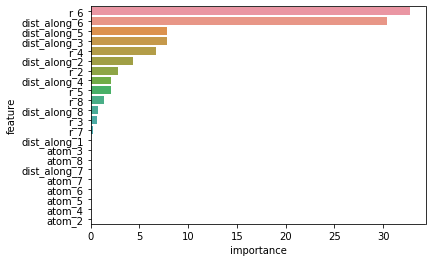

In [36]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

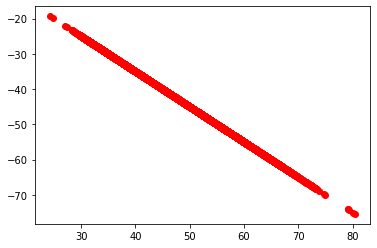

In [37]:
plt.plot(y_val, y_pred - y_val, 'ro')

## LGBMRegressor

In [38]:
#aaa

In [39]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 150,
    'min_child_samples': 30,
    'max_depth': 9,
    'reg_alpha': 0.01,
    'reg_lambda': 0.3,
    'bagging_freq': 2000,
    'bagging_fraction': 0.7,
    'bagging_seed': 11,
    'colsample_bytree': 1.0
}

In [40]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.85174	valid_1's l1: 0.934214
[200]	training's l1: 0.557773	valid_1's l1: 0.663922
[300]	training's l1: 0.500091	valid_1's l1: 0.617761
[400]	training's l1: 0.462999	valid_1's l1: 0.58986
[500]	training's l1: 0.43546	valid_1's l1: 0.570156
[600]	training's l1: 0.412264	valid_1's l1: 0.554424
[700]	training's l1: 0.393253	valid_1's l1: 0.541867
[800]	training's l1: 0.378643	valid_1's l1: 0.532471
[900]	training's l1: 0.364859	valid_1's l1: 0.523863
[1000]	training's l1: 0.353806	valid_1's l1: 0.517761
[1100]	training's l1: 0.343525	valid_1's l1: 0.512235
[1200]	training's l1: 0.333603	valid_1's l1: 0.507235
[1300]	training's l1: 0.324915	valid_1's l1: 0.503298
[1400]	training's l1: 0.316866	valid_1's l1: 0.499526
[1500]	training's l1: 0.310438	valid_1's l1: 0.4968
[1600]	training's l1: 0.304204	valid_1's l1: 0.493967
[1700]	training's l1: 0.297653	valid_1's l1: 0.491083
[1800]	training's l1: 0.291173	va

-0.8742548560958345

Not a bad score for such a simple set of features.

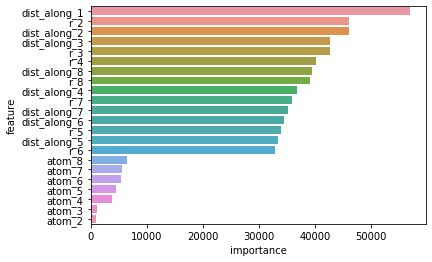

In [41]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

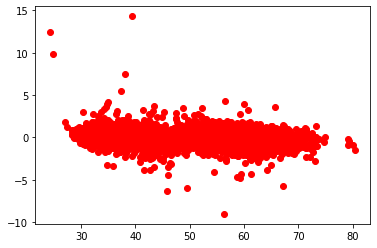

In [42]:
plt.plot(y_val, y_pred- y_val, 'ro')

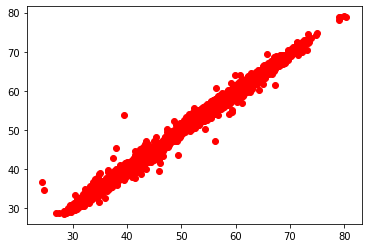

In [48]:
plt.plot(y_val, y_pred, 'ro')

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model


In [43]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    
    return X_data, y_data

In [44]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    model_type =  'lgb' #lgb  cat
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        if model_type == 'lgb':
            model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=200)
        
        if model_type == 'cat': 
            categorical_features = [col for col in X_train if col.startswith('atom_')]
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [45]:
categorical_features

['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8']

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [46]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }
model_params = {
    '1JHC': 7,
    '1JHN': 7,    
    '2JHH': 7,
    '2JHN': 7,
    '2JHC': 7,
    '3JHH': 7,
    '3JHC': 7,
    '3JHN': 7
}


Checking cross-validation scores for each type:

In [47]:
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHC ***


KeyboardInterrupt: 

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## a!!!